<a href="https://colab.research.google.com/github/jhtwiz/AI-1-jhtwiz/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace로 두 문장의 논리적 모순 분류하기

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00


In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
db = load_dataset("nyu-mll/glue", "mnli")
db

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [4]:
db['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

In [5]:
db['train'].features['label'].names

['entailment', 'neutral', 'contradiction']

In [6]:
len_classes = len(db['train'].features['label'].names)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(data["premise"], data["hypothesis"])

db_tokenized = db.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [7]:
db_tokenized['train'][0].keys()

dict_keys(['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
db_split = db_tokenized['train'].train_test_split(test_size=0.2)
db_train, db_val = db_split['train'], db_split['test']
db_test = db_tokenized['validation_matched']

In [9]:
len(db_train), len(db_val), len(db_test)

(314161, 78541, 9815)

In [12]:
print('====premise====')
print(db_train[0]['premise'])
print('====hypothesis====')
print(db_train[0]['hypothesis'])
print('====final input====')
print(tokenizer.convert_ids_to_tokens(db_train[0]['input_ids']))

====premise====
Time 's education cover package says parents should get their kids reading at an early age, be involved in their schools, not castigate them for mistakes, let them find their own learning styles, and praise hard work and persistence--not just outcomes.
====hypothesis====
Positive reinforcement and early learning are beneficial to childhood development.
====final input====
['[CLS]', 'Time', "'", 's', 'education', 'cover', 'package', 'says', 'parents', 'should', 'get', 'their', 'kids', 'reading', 'at', 'an', 'early', 'age', ',', 'be', 'involved', 'in', 'their', 'schools', ',', 'not', 'cast', '##igate', 'them', 'for', 'mistakes', ',', 'let', 'them', 'find', 'their', 'own', 'learning', 'styles', ',', 'and', 'praise', 'hard', 'work', 'and', 'per', '##sistence', '-', '-', 'not', 'just', 'outcomes', '.', '[SEP]', 'Po', '##sitive', 'reinforce', '##ment', 'and', 'early', 'learning', 'are', 'beneficial', 'to', 'childhood', 'development', '.', '[SEP]']


**모델에 넘겨줄 input_ids가 잘 합쳐진 것을 확인 가능하다.([SEP]으로 확인가능)**

In [13]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 128  # BERT layer의 기본 hidden dimension
config.intermediate_size = 256  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 5  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = len_classes  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer_mnli',  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-4,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

In [17]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=db_train,
    eval_dataset=db_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.998200,0.931469,0.551177
2,0.892300,0.897166,0.578946
3,0.846400,0.889788,0.585414
4,0.813500,0.892903,0.585312
5,0.785000,0.911048,0.585567


TrainOutput(global_step=12275, training_loss=0.8671053772594196, metrics={'train_runtime': 1162.1913, 'train_samples_per_second': 2703.178, 'train_steps_per_second': 21.124, 'total_flos': 813046337052810.0, 'train_loss': 0.8671053772594196, 'epoch': 5.0})

In [ ]:
trainer.evaluate(db_test)

{'eval_loss': 0.9074538946151733,
 'eval_accuracy': 0.5751400916963831,
 'eval_runtime': 3.0248,
 'eval_samples_per_second': 3244.796,
 'eval_steps_per_second': 25.456,
 'epoch': 5.0}

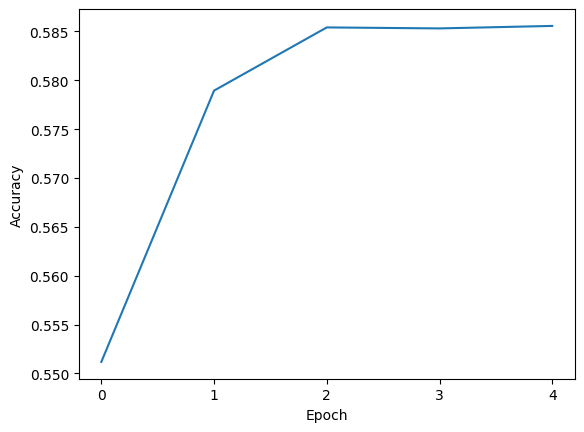

In [26]:
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history
train_acc = [log["eval_accuracy"] for log in train_logs if "eval_accuracy" in log]

plt.plot(train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([0, 1, 2, 3, 4])

plt.show()